🔹 1. Imports & Configurations

In [ ]:
# === Basic Utilities ===
import os, random, shutil, warnings
from pathlib import Path
from collections import defaultdict
from collections import Counter

# === Data Handling ===
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from time import time

# === Visualization ===
import seaborn as sns
import matplotlib.pyplot as plt

# === Image Handling ===
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
warnings.simplefilter('error', Image.DecompressionBombWarning)

# === TensorFlow & Keras ===
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers


# === CLIP (for filtering) ===
import clip
import torch
from tqdm import tqdm

from sklearn.cluster import DBSCAN
from collections import Counter, defaultdict

# === Paths ===
metadata_path = r"C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\metadata.csv"
source_dir = r"C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\rare_species1"
dest_dir = r"C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\rare_species_filtered"
dest_dir_clip = r"C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\rare_species_final"
dest_dir_removed = r"C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\rare_species_removed"

c:\Users\Elcano\anaconda3\envs\cv310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load metadata
metadata = pd.read_csv(metadata_path)
"""
This cell loads the metadata CSV file and analyzes the distribution of images across families.
It counts and calculates the percentage of images per family to assess dataset balance.
The output helps identify potential class imbalances that may need addressing.
"""
# Calculate image counts per family
family_stats = metadata['family'].value_counts().reset_index()
family_stats.columns = ['Family', 'Image Count']
family_stats['Percentage'] = (family_stats['Image Count'] / family_stats['Image Count'].sum()) * 100

# Display results
print("Dataset Balance by Family:")
print(family_stats.to_string(index=False))

Dataset Balance by Family:
           Family  Image Count  Percentage
  cercopithecidae          300    2.503547
      dactyloidae          300    2.503547
       formicidae          291    2.428440
   plethodontidae          270    2.253192
   carcharhinidae          270    2.253192
    salamandridae          270    2.253192
          bovidae          240    2.002837
      bucerotidae          210    1.752483
      acroporidae          210    1.752483
         anatidae          180    1.502128
      diomedeidae          180    1.502128
         atelidae          150    1.251773
          laridae          150    1.251773
           apidae          150    1.251773
        bufonidae          150    1.251773
       dasyatidae          150    1.251773
      delphinidae          120    1.001419
      agariciidae          120    1.001419
   callitrichidae          120    1.001419
      psittacidae          120    1.001419
     spheniscidae          120    1.001419
        iguanidae          

In [3]:
"""
This cell loads the metadata CSV file and analyzes the distribution of images across families.
It counts and calculates the percentage of images per family to assess dataset balance.
The output helps identify potential class imbalances that may need addressing.
"""
# Calculate image counts per family
family_stats = metadata['phylum'].value_counts().reset_index()
family_stats.columns = ['phylum', 'Image Count']
family_stats['Percentage'] = (family_stats['Image Count'] / family_stats['Image Count'].sum()) * 100

# Display results
print("Dataset Balance by phylum:")
print(family_stats.to_string(index=False))

Dataset Balance by phylum:
       phylum  Image Count  Percentage
     chordata         9952   83.050989
   arthropoda          951    7.936243
     cnidaria          810    6.759576
     mollusca          210    1.752483
echinodermata           60    0.500709


🔹 2. Image Filtering (Low Quality & Corrupted)

In [5]:
valid_formats = ['jpeg', 'jpg', 'png', 'bmp']
min_size_kb = 5
max_pixels = 89_478_485

os.makedirs(dest_dir, exist_ok=True)

total_images = valid_images = removed_small = removed_too_large = removed_invalid = 0

for family_folder in os.listdir(source_dir):
    src_path = os.path.join(source_dir, family_folder)
    dst_path = os.path.join(dest_dir, family_folder)
    os.makedirs(dst_path, exist_ok=True)

    for file in os.listdir(src_path):
        total_images += 1
        file_path = os.path.join(src_path, file)
        try:
            if os.path.getsize(file_path) < min_size_kb * 1024:
                removed_small += 1
                continue
            with Image.open(file_path) as img:
                if img.format.lower() not in valid_formats:
                    removed_invalid += 1
                    continue
                if img.width * img.height > max_pixels:
                    removed_too_large += 1
                    continue
                img.verify()
            shutil.copy2(file_path, os.path.join(dst_path, file))
            valid_images += 1
        except Exception:
            removed_invalid += 1

print(f"\nImage filtering complete. Valid: {valid_images}, Removed: {total_images - valid_images}")


Image filtering complete. Valid: 11972, Removed: 11


🔹 3. CLIP-Based Filtering (Similarity)

In [ ]:
# Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

dest_dir = r"C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\rare_species_filtered"
dest_dir_clip = r"C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\rare_species_final"
dest_dir_removed = r"C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\rare_species_removed"

def get_clip_embedding(image_path):
    try:
        img = Image.open(image_path).convert("RGB")
        img_tensor = preprocess(img).unsqueeze(0).to(device)
        with torch.no_grad():
            return model.encode_image(img_tensor).cpu().numpy()[0]
    except Exception as e:
        print(f" Error processing {image_path}: {e}")
        return None

# Track removals
removal_counter = defaultdict(int)
total_removed = 0
total_processed = 0

folder_counter = 0
for folder in tqdm(os.listdir(dest_dir), desc="CLIP cleaning"):
    folder_counter += 1
    fpath = os.path.join(dest_dir, folder)
    f_keep = os.path.join(dest_dir_clip, folder)
    f_rm = os.path.join(dest_dir_removed, folder)
    os.makedirs(f_keep, exist_ok=True)
    os.makedirs(f_rm, exist_ok=True)

    image_paths, embeddings = [], []
    for file in os.listdir(fpath):
        full_path = os.path.join(fpath, file)
        emb = get_clip_embedding(full_path)
        if emb is not None:
            image_paths.append(full_path)
            embeddings.append(emb)

    total_processed += len(image_paths)

    if len(embeddings) < 3:
        for img in image_paths:
            shutil.copy2(img, os.path.join(f_keep, os.path.basename(img)))
        print(f"\n {folder}: Kept all {len(image_paths)} images (too few for clustering)")
        continue

    embeddings = np.vstack(embeddings)

    # Clustering with DBSCAN
    db = DBSCAN(eps=0.3, min_samples=2, metric="cosine").fit(embeddings)
    labels = db.labels_

    if len(set(labels)) == 1 and -1 in labels:
        print(f"\n {folder}: All images marked as noise. Keeping all.")
        for img in image_paths:
            shutil.copy2(img, os.path.join(f_keep, os.path.basename(img)))
        continue

    label_counts = Counter(labels)
    label_counts.pop(-1, None)
    if not label_counts:
        print(f"\n {folder}: No valid clusters found. Keeping all.")
        for img in image_paths:
            shutil.copy2(img, os.path.join(f_keep, os.path.basename(img)))
        continue

    majority_label = label_counts.most_common(1)[0][0]
    kept_files = []
    removed_files = []

    for i, img_path in enumerate(image_paths):
        filename = os.path.basename(img_path)
        if labels[i] == majority_label:
            shutil.copy2(img_path, os.path.join(f_keep, filename))
            kept_files.append(filename)
        else:
            shutil.copy2(img_path, os.path.join(f_rm, filename))
            removed_files.append(filename)

    removal_counter[folder] += len(removed_files)
    total_removed += len(removed_files)

    print(f"\n {folder}:")
    print(f"   Kept: {len(kept_files)}/{len(image_paths)} ({100 * len(kept_files) / len(image_paths):.1f}%)")
    print(f"   Removed: {len(removed_files)}")

    if folder_counter <= 5:
        print(f" Examples:")
        print(f"    Kept    : {kept_files[:5]}")
        print(f"    Removed : {removed_files[:5]}")

# Final Summary
print("\n===  CLIP + Clustering Complete ===")
print(f" Final images saved to: {dest_dir_clip}")
print(f" Removed images saved to: {dest_dir_removed}")

print("\n Removal Summary Per Family:")
for family, removed in removal_counter.items():
    print(f" - {family}: {removed} images removed")

print(f"\n Total Removed: {total_removed} / {total_processed} images")
print(f" Percentage Removed: {100 * total_removed / total_processed:.2f}%")



CLIP cleaning:   0%|          | 1/202 [00:24<1:22:34, 24.65s/it]


 arthropoda_apidae:
   Kept: 150/150 (100.0%)
   Removed: 0
  🔎 Examples:
    Kept    : ['20647903_1065369_eol-full-size-copy.jpg', '20647904_1065369_eol-full-size-copy.jpg', '20647909_1065369_eol-full-size-copy.jpg', '20647915_1065369_eol-full-size-copy.jpg', '21834153_1065290_eol-full-size-copy.jpg']
    Removed : []


CLIP cleaning:   1%|          | 2/202 [00:29<43:46, 13.13s/it]  


 arthropoda_attelabidae:
   Kept: 29/30 (96.7%)
   Removed: 1
  🔎 Examples:
    Kept    : ['14088426_52691998_eol-full-size-copy.jpg', '14088427_52691998_eol-full-size-copy.jpg', '14088429_52691998_eol-full-size-copy.jpg', '14088430_52691998_eol-full-size-copy.jpg', '22864939_52691998_eol-full-size-copy.jpg']
    Removed : ['29600192_52691998_eol-full-size-copy.jpg']


CLIP cleaning:   1%|▏         | 3/202 [00:38<36:42, 11.07s/it]


 arthropoda_carabidae:
   Kept: 59/60 (98.3%)
   Removed: 1
  🔎 Examples:
    Kept    : ['10787825_2867406_eol-full-size-copy.jpg', '10787827_2867406_eol-full-size-copy.jpg', '10787828_2867406_eol-full-size-copy.jpg', '10787831_2867406_eol-full-size-copy.jpg', '10787833_2867406_eol-full-size-copy.jpg']
    Removed : ['28933416_2867406_eol-full-size-copy.jpg']


CLIP cleaning:   2%|▏         | 4/202 [00:43<28:13,  8.56s/it]


 arthropoda_cerambycidae:
   Kept: 28/29 (96.6%)
   Removed: 1
  🔎 Examples:
    Kept    : ['14204113_354871_eol-full-size-copy.jpg', '22538999_354871_eol-full-size-copy.jpg', '22539000_354871_eol-full-size-copy.jpg', '22539001_354871_eol-full-size-copy.jpg', '22539002_354871_eol-full-size-copy.jpg']
    Removed : ['28255130_354871_eol-full-size-copy.jpg']


CLIP cleaning:   2%|▏         | 5/202 [00:46<22:30,  6.85s/it]


 arthropoda_coenagrionidae:
   Kept: 30/30 (100.0%)
   Removed: 0
  🔎 Examples:
    Kept    : ['20710764_1001090_eol-full-size-copy.jpg', '20710765_1001090_eol-full-size-copy.jpg', '20710766_1001090_eol-full-size-copy.jpg', '20710768_1001090_eol-full-size-copy.jpg', '20710770_1001090_eol-full-size-copy.jpg']
    Removed : []


CLIP cleaning:   3%|▎         | 6/202 [01:24<56:35, 17.33s/it]


 arthropoda_formicidae:
   Kept: 253/291 (86.9%)
   Removed: 38


CLIP cleaning:   3%|▎         | 7/202 [01:33<47:43, 14.68s/it]


 arthropoda_gomphidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:   4%|▍         | 8/202 [01:37<36:40, 11.34s/it]


 arthropoda_lucanidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:   4%|▍         | 9/202 [01:43<30:52,  9.60s/it]


 arthropoda_nymphalidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:   5%|▍         | 10/202 [01:48<25:57,  8.11s/it]


 arthropoda_palinuridae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:   5%|▌         | 11/202 [01:53<22:30,  7.07s/it]


 arthropoda_papilionidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:   6%|▌         | 12/202 [01:57<19:15,  6.08s/it]


 arthropoda_pisauridae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:   6%|▋         | 13/202 [02:01<18:00,  5.72s/it]


 arthropoda_platystictidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:   7%|▋         | 14/202 [02:07<18:01,  5.75s/it]


 arthropoda_pseudophasmatidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:   7%|▋         | 15/202 [02:12<17:20,  5.56s/it]


 arthropoda_tettigoniidae:
   Kept: 28/30 (93.3%)
   Removed: 2


CLIP cleaning:   8%|▊         | 16/202 [02:18<17:01,  5.49s/it]


 arthropoda_theraphosidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:   8%|▊         | 17/202 [02:22<15:54,  5.16s/it]


 arthropoda_triopsidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:   9%|▉         | 18/202 [02:42<29:38,  9.66s/it]


 chordata_accipitridae:
   Kept: 118/119 (99.2%)
   Removed: 1


CLIP cleaning:   9%|▉         | 19/202 [02:56<33:26, 10.96s/it]


 chordata_acipenseridae:
   Kept: 88/90 (97.8%)
   Removed: 2


CLIP cleaning:  10%|▉         | 20/202 [03:05<31:38, 10.43s/it]


 chordata_agamidae:
   Kept: 59/60 (98.3%)
   Removed: 1


CLIP cleaning:  10%|█         | 21/202 [03:10<26:06,  8.65s/it]


 chordata_albulidae:
   Kept: 28/30 (93.3%)
   Removed: 2


CLIP cleaning:  11%|█         | 22/202 [03:15<22:29,  7.50s/it]


 chordata_alcedinidae:
   Kept: 27/30 (90.0%)
   Removed: 3


CLIP cleaning:  11%|█▏        | 23/202 [03:20<20:02,  6.72s/it]


 chordata_alligatoridae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  12%|█▏        | 24/202 [03:28<21:00,  7.08s/it]


 chordata_alopiidae:
   Kept: 57/60 (95.0%)
   Removed: 3


CLIP cleaning:  12%|█▏        | 25/202 [03:36<22:04,  7.48s/it]


 chordata_ambystomatidae:
   Kept: 57/60 (95.0%)
   Removed: 3


CLIP cleaning:  13%|█▎        | 26/202 [04:04<39:50, 13.58s/it]


 chordata_anatidae:
   Kept: 166/180 (92.2%)
   Removed: 14


CLIP cleaning:  13%|█▎        | 27/202 [04:13<35:32, 12.18s/it]


 chordata_anguidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  14%|█▍        | 28/202 [04:21<31:52, 10.99s/it]


 chordata_aotidae:
   Kept: 36/60 (60.0%)
   Removed: 24


CLIP cleaning:  14%|█▍        | 29/202 [04:30<30:20, 10.52s/it]


 chordata_ardeidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  15%|█▍        | 30/202 [04:34<24:40,  8.60s/it]


 chordata_arthroleptidae:
   Kept: 25/30 (83.3%)
   Removed: 5


CLIP cleaning:  15%|█▌        | 31/202 [04:57<36:37, 12.85s/it]


 chordata_atelidae:
   Kept: 86/150 (57.3%)
   Removed: 64


CLIP cleaning:  16%|█▌        | 32/202 [05:02<29:21, 10.36s/it]


 chordata_balaenicipitidae:
   Kept: 23/30 (76.7%)
   Removed: 7


CLIP cleaning:  16%|█▋        | 33/202 [05:06<24:16,  8.62s/it]


 chordata_balaenidae:
   Kept: 27/30 (90.0%)
   Removed: 3


CLIP cleaning:  17%|█▋        | 34/202 [05:11<20:47,  7.43s/it]


 chordata_balaenopteridae:
   Kept: 28/30 (93.3%)
   Removed: 2


CLIP cleaning:  17%|█▋        | 35/202 [05:21<22:30,  8.09s/it]


 chordata_balistidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  18%|█▊        | 36/202 [05:25<19:18,  6.98s/it]


 chordata_bombycillidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  18%|█▊        | 37/202 [06:05<46:05, 16.76s/it]


 chordata_bovidae:
   Kept: 234/240 (97.5%)
   Removed: 6


CLIP cleaning:  19%|█▉        | 38/202 [06:09<35:48, 13.10s/it]


 chordata_brachypteraciidae:
   Kept: 21/30 (70.0%)
   Removed: 9


CLIP cleaning:  19%|█▉        | 39/202 [06:51<58:49, 21.65s/it]


 chordata_bucerotidae:
   Kept: 205/210 (97.6%)
   Removed: 5


CLIP cleaning:  20%|█▉        | 40/202 [07:17<1:02:24, 23.12s/it]


 chordata_bufonidae:
   Kept: 150/150 (100.0%)
   Removed: 0


CLIP cleaning:  20%|██        | 41/202 [07:29<52:50, 19.69s/it]  


 chordata_burhinidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  21%|██        | 42/202 [07:34<40:46, 15.29s/it]


 chordata_cacatuidae:
   Kept: 24/30 (80.0%)
   Removed: 6


CLIP cleaning:  21%|██▏       | 43/202 [07:53<43:28, 16.40s/it]


 chordata_callitrichidae:
   Kept: 85/120 (70.8%)
   Removed: 35


CLIP cleaning:  22%|██▏       | 44/202 [07:59<34:34, 13.13s/it]


 chordata_callorhinchidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  22%|██▏       | 45/202 [08:03<27:52, 10.65s/it]


 chordata_caprimulgidae:
   Kept: 26/30 (86.7%)
   Removed: 4


CLIP cleaning:  23%|██▎       | 46/202 [08:47<53:22, 20.53s/it]


 chordata_carcharhinidae:
   Kept: 267/269 (99.3%)
   Removed: 2


CLIP cleaning:  23%|██▎       | 47/202 [08:53<41:27, 16.05s/it]


 chordata_carettochelyidae:
   Kept: 29/29 (100.0%)
   Removed: 0


CLIP cleaning:  24%|██▍       | 48/202 [09:09<41:31, 16.18s/it]


 chordata_cebidae:
   Kept: 85/90 (94.4%)
   Removed: 5


CLIP cleaning:  24%|██▍       | 49/202 [10:03<1:10:01, 27.46s/it]


 chordata_cercopithecidae:
   Kept: 299/300 (99.7%)
   Removed: 1


CLIP cleaning:  25%|██▍       | 50/202 [10:08<52:55, 20.89s/it]  


 chordata_cervidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  25%|██▌       | 51/202 [10:13<39:56, 15.87s/it]


 chordata_cetorhinidae:
   Kept: 27/30 (90.0%)
   Removed: 3


CLIP cleaning:  26%|██▌       | 52/202 [10:20<33:35, 13.44s/it]


 chordata_chaetodontidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  26%|██▌       | 53/202 [10:28<29:25, 11.85s/it]


 chordata_chamaeleonidae:
   Kept: 56/57 (98.2%)
   Removed: 1


CLIP cleaning:  27%|██▋       | 54/202 [10:37<27:04, 10.98s/it]


 chordata_charadriidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  27%|██▋       | 55/202 [10:42<22:18,  9.10s/it]


 chordata_cheirogaleidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  28%|██▊       | 56/202 [10:53<23:12,  9.54s/it]


 chordata_chelidae:
   Kept: 57/57 (100.0%)
   Removed: 0


CLIP cleaning:  28%|██▊       | 57/202 [10:57<19:17,  7.98s/it]


 chordata_cheloniidae:
   Kept: 27/30 (90.0%)
   Removed: 3


CLIP cleaning:  29%|██▊       | 58/202 [11:02<16:44,  6.98s/it]


 chordata_chelydridae:
   Kept: 26/30 (86.7%)
   Removed: 4


CLIP cleaning:  29%|██▉       | 59/202 [11:18<23:34,  9.89s/it]


 chordata_ciconiidae:
   Kept: 87/90 (96.7%)
   Removed: 3


CLIP cleaning:  30%|██▉       | 60/202 [11:32<26:02, 11.00s/it]


 chordata_colubridae:
   Kept: 90/90 (100.0%)
   Removed: 0


CLIP cleaning:  30%|███       | 61/202 [11:37<21:57,  9.35s/it]


 chordata_columbidae:
   Kept: 27/30 (90.0%)
   Removed: 3


CLIP cleaning:  31%|███       | 62/202 [11:49<23:02,  9.87s/it]


 chordata_cracidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  31%|███       | 63/202 [11:54<19:33,  8.44s/it]


 chordata_cricetidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  32%|███▏      | 64/202 [12:04<20:36,  8.96s/it]


 chordata_crocodylidae:
   Kept: 58/60 (96.7%)
   Removed: 2


CLIP cleaning:  32%|███▏      | 65/202 [12:14<21:22,  9.36s/it]


 chordata_cryptobranchidae:
   Kept: 57/60 (95.0%)
   Removed: 3


CLIP cleaning:  33%|███▎      | 66/202 [12:18<17:48,  7.86s/it]


 chordata_ctenomyidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  33%|███▎      | 67/202 [12:23<15:09,  6.74s/it]


 chordata_cuculidae:
   Kept: 27/30 (90.0%)
   Removed: 3


CLIP cleaning:  34%|███▎      | 68/202 [12:27<13:16,  5.94s/it]


 chordata_cyprinodontidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  34%|███▍      | 69/202 [13:07<36:21, 16.40s/it]


 chordata_dactyloidae:
   Kept: 300/300 (100.0%)
   Removed: 0


CLIP cleaning:  35%|███▍      | 70/202 [13:11<27:54, 12.68s/it]


 chordata_dalatiidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  35%|███▌      | 71/202 [13:33<33:39, 15.42s/it]


 chordata_dasyatidae:
   Kept: 146/150 (97.3%)
   Removed: 4


CLIP cleaning:  36%|███▌      | 72/202 [13:39<27:04, 12.50s/it]


 chordata_dasypodidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  36%|███▌      | 73/202 [13:44<21:45, 10.12s/it]


 chordata_dasyuridae:
   Kept: 28/30 (93.3%)
   Removed: 2


CLIP cleaning:  37%|███▋      | 74/202 [13:48<18:14,  8.55s/it]


 chordata_daubentoniidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  37%|███▋      | 75/202 [14:06<23:35, 11.15s/it]


 chordata_delphinidae:
   Kept: 116/119 (97.5%)
   Removed: 3


CLIP cleaning:  38%|███▊      | 76/202 [14:10<19:03,  9.08s/it]


 chordata_dendrobatidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  38%|███▊      | 77/202 [14:41<32:56, 15.81s/it]


 chordata_diomedeidae:
   Kept: 170/179 (95.0%)
   Removed: 9


CLIP cleaning:  39%|███▊      | 78/202 [14:50<28:16, 13.68s/it]


 chordata_diplodactylidae:
   Kept: 58/60 (96.7%)
   Removed: 2


CLIP cleaning:  39%|███▉      | 79/202 [14:55<22:36, 11.03s/it]


 chordata_elapidae:
   Kept: 28/30 (93.3%)
   Removed: 2


CLIP cleaning:  40%|███▉      | 80/202 [15:06<22:18, 10.97s/it]


 chordata_emydidae:
   Kept: 57/60 (95.0%)
   Removed: 3


CLIP cleaning:  40%|████      | 81/202 [15:12<19:04,  9.46s/it]


 chordata_equidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  41%|████      | 82/202 [15:16<15:57,  7.98s/it]


 chordata_estrildidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  41%|████      | 83/202 [15:27<17:40,  8.91s/it]


 chordata_falconidae:
   Kept: 59/60 (98.3%)
   Removed: 1


CLIP cleaning:  42%|████▏     | 84/202 [15:37<17:42,  9.01s/it]


 chordata_fringillidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  42%|████▏     | 85/202 [15:42<15:29,  7.94s/it]


 chordata_gavialidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  43%|████▎     | 86/202 [15:47<13:42,  7.09s/it]


 chordata_gekkonidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  43%|████▎     | 87/202 [16:02<18:09,  9.47s/it]


 chordata_geoemydidae:
   Kept: 88/90 (97.8%)
   Removed: 2


CLIP cleaning:  44%|████▎     | 88/202 [16:06<14:53,  7.84s/it]


 chordata_giraffidae:
   Kept: 26/29 (89.7%)
   Removed: 3


CLIP cleaning:  44%|████▍     | 89/202 [16:11<12:51,  6.83s/it]


 chordata_glareolidae:
   Kept: 28/30 (93.3%)
   Removed: 2


CLIP cleaning:  45%|████▍     | 90/202 [16:16<11:40,  6.25s/it]


 chordata_gliridae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  45%|████▌     | 91/202 [16:22<11:34,  6.26s/it]


 chordata_goodeidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  46%|████▌     | 92/202 [16:26<10:26,  5.69s/it]


 chordata_gymnuridae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  46%|████▌     | 93/202 [16:32<10:28,  5.77s/it]


 chordata_hemiscylliidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  47%|████▋     | 94/202 [16:41<11:55,  6.63s/it]


 chordata_hexanchidae:
   Kept: 58/60 (96.7%)
   Removed: 2


CLIP cleaning:  47%|████▋     | 95/202 [16:47<11:21,  6.37s/it]


 chordata_hominidae:
   Kept: 25/30 (83.3%)
   Removed: 5


CLIP cleaning:  48%|████▊     | 96/202 [16:51<10:21,  5.86s/it]


 chordata_hyaenidae:
   Kept: 27/30 (90.0%)
   Removed: 3


CLIP cleaning:  48%|████▊     | 97/202 [17:07<15:18,  8.75s/it]


 chordata_hylobatidae:
   Kept: 52/90 (57.8%)
   Removed: 38


CLIP cleaning:  49%|████▊     | 98/202 [17:10<12:33,  7.25s/it]


 chordata_hynobiidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  49%|████▉     | 99/202 [17:32<19:37, 11.43s/it]


 chordata_iguanidae:
   Kept: 118/120 (98.3%)
   Removed: 2


CLIP cleaning:  50%|████▉     | 100/202 [17:37<16:19,  9.60s/it]


 chordata_indriidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  50%|█████     | 101/202 [17:47<16:13,  9.64s/it]


 chordata_labridae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  50%|█████     | 102/202 [17:56<15:59,  9.60s/it]


 chordata_lacertidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  51%|█████     | 103/202 [18:00<13:13,  8.01s/it]


 chordata_lamnidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  51%|█████▏    | 104/202 [18:24<20:43, 12.69s/it]


 chordata_laridae:
   Kept: 147/149 (98.7%)
   Removed: 2


CLIP cleaning:  52%|█████▏    | 105/202 [18:29<16:48, 10.40s/it]


 chordata_latimeriidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  52%|█████▏    | 106/202 [18:40<17:02, 10.65s/it]


 chordata_lemuridae:
   Kept: 59/60 (98.3%)
   Removed: 1


CLIP cleaning:  53%|█████▎    | 107/202 [18:51<16:57, 10.71s/it]


 chordata_leporidae:
   Kept: 58/60 (96.7%)
   Removed: 2


CLIP cleaning:  53%|█████▎    | 108/202 [18:55<13:33,  8.65s/it]


 chordata_lutjanidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  54%|█████▍    | 109/202 [19:04<13:37,  8.79s/it]


 chordata_manidae:
   Kept: 56/60 (93.3%)
   Removed: 4


CLIP cleaning:  54%|█████▍    | 110/202 [19:10<11:54,  7.77s/it]


 chordata_mantellidae:
   Kept: 28/30 (93.3%)
   Removed: 2


CLIP cleaning:  55%|█████▍    | 111/202 [19:14<10:25,  6.88s/it]


 chordata_megapodiidae:
   Kept: 28/30 (93.3%)
   Removed: 2


CLIP cleaning:  55%|█████▌    | 112/202 [19:18<08:59,  5.99s/it]


 chordata_merlucciidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  56%|█████▌    | 113/202 [19:23<08:08,  5.49s/it]


 chordata_mesitornithidae:
   Kept: 19/30 (63.3%)
   Removed: 11


CLIP cleaning:  56%|█████▋    | 114/202 [19:28<07:46,  5.30s/it]


 chordata_mimidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  57%|█████▋    | 115/202 [19:33<07:49,  5.40s/it]


 chordata_motacillidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  57%|█████▋    | 116/202 [19:38<07:34,  5.28s/it]


 chordata_muscicapidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  58%|█████▊    | 117/202 [19:57<13:24,  9.46s/it]


 chordata_mustelidae:
   Kept: 89/90 (98.9%)
   Removed: 1


CLIP cleaning:  58%|█████▊    | 118/202 [20:10<14:46, 10.56s/it]


 chordata_myliobatidae:
   Kept: 90/90 (100.0%)
   Removed: 0


CLIP cleaning:  59%|█████▉    | 119/202 [20:17<12:45,  9.22s/it]


 chordata_nesospingidae:
   Kept: 20/30 (66.7%)
   Removed: 10


CLIP cleaning:  59%|█████▉    | 120/202 [20:21<10:31,  7.70s/it]


 chordata_odontophoridae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  60%|█████▉    | 121/202 [20:30<10:56,  8.10s/it]


 chordata_otariidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  60%|██████    | 122/202 [20:35<09:40,  7.26s/it]


 chordata_otididae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  61%|██████    | 123/202 [20:40<08:35,  6.52s/it]


 chordata_pangasiidae:
   Kept: 28/30 (93.3%)
   Removed: 2


CLIP cleaning:  61%|██████▏   | 124/202 [20:44<07:39,  5.89s/it]


 chordata_paradisaeidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  62%|██████▏   | 125/202 [20:49<07:02,  5.48s/it]


 chordata_pardalotidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  62%|██████▏   | 126/202 [20:53<06:21,  5.02s/it]


 chordata_parulidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  63%|██████▎   | 127/202 [20:57<05:59,  4.79s/it]


 chordata_percidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  63%|██████▎   | 128/202 [21:02<05:59,  4.86s/it]


 chordata_phasianidae:
   Kept: 26/29 (89.7%)
   Removed: 3


CLIP cleaning:  64%|██████▍   | 129/202 [21:06<05:45,  4.73s/it]


 chordata_phrynosomatidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  64%|██████▍   | 130/202 [21:11<05:33,  4.63s/it]


 chordata_phyllomedusidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  65%|██████▍   | 131/202 [21:16<05:30,  4.65s/it]


 chordata_phyllostomidae:
   Kept: 26/30 (86.7%)
   Removed: 4


CLIP cleaning:  65%|██████▌   | 132/202 [21:21<05:32,  4.75s/it]


 chordata_pittidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  66%|██████▌   | 133/202 [22:05<19:00, 16.53s/it]


 chordata_plethodontidae:
   Kept: 270/270 (100.0%)
   Removed: 0


CLIP cleaning:  66%|██████▋   | 134/202 [22:09<14:35, 12.88s/it]


 chordata_pleuronectidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  67%|██████▋   | 135/202 [22:16<12:26, 11.14s/it]


 chordata_podocnemididae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  67%|██████▋   | 136/202 [22:21<10:14,  9.31s/it]


 chordata_polyprionidae:
   Kept: 26/30 (86.7%)
   Removed: 4


CLIP cleaning:  68%|██████▊   | 137/202 [22:26<08:35,  7.94s/it]


 chordata_pontoporiidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  68%|██████▊   | 138/202 [22:31<07:33,  7.09s/it]


 chordata_potoroidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  69%|██████▉   | 139/202 [22:36<06:42,  6.39s/it]


 chordata_pristidae:
   Kept: 27/30 (90.0%)
   Removed: 3


CLIP cleaning:  69%|██████▉   | 140/202 [22:55<10:35, 10.25s/it]


 chordata_procellariidae:
   Kept: 87/90 (96.7%)
   Removed: 3


CLIP cleaning:  70%|██████▉   | 141/202 [23:17<14:07, 13.90s/it]


 chordata_psittacidae:
   Kept: 116/120 (96.7%)
   Removed: 4


CLIP cleaning:  70%|███████   | 142/202 [23:28<12:50, 12.85s/it]


 chordata_psittaculidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  71%|███████   | 143/202 [23:42<12:55, 13.14s/it]


 chordata_pythonidae:
   Kept: 58/60 (96.7%)
   Removed: 2


CLIP cleaning:  71%|███████▏  | 144/202 [23:56<13:00, 13.45s/it]


 chordata_rajidae:
   Kept: 89/90 (98.9%)
   Removed: 1


CLIP cleaning:  72%|███████▏  | 145/202 [24:03<10:54, 11.49s/it]


 chordata_rallidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  72%|███████▏  | 146/202 [24:08<09:04,  9.72s/it]


 chordata_ramphastidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  73%|███████▎  | 147/202 [24:22<10:04, 10.99s/it]


 chordata_ranidae:
   Kept: 90/90 (100.0%)
   Removed: 0


CLIP cleaning:  73%|███████▎  | 148/202 [24:27<08:11,  9.09s/it]


 chordata_recurvirostridae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  74%|███████▍  | 149/202 [24:38<08:28,  9.60s/it]


 chordata_rhacophoridae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  74%|███████▍  | 150/202 [24:41<06:46,  7.82s/it]


 chordata_rhinodermatidae:
   Kept: 28/30 (93.3%)
   Removed: 2


CLIP cleaning:  75%|███████▍  | 151/202 [24:50<06:52,  8.09s/it]


 chordata_rhyacotritonidae:
   Kept: 59/60 (98.3%)
   Removed: 1


CLIP cleaning:  75%|███████▌  | 152/202 [25:30<14:44, 17.68s/it]


 chordata_salamandridae:
   Kept: 270/270 (100.0%)
   Removed: 0


CLIP cleaning:  76%|███████▌  | 153/202 [25:35<11:22, 13.93s/it]


 chordata_salmonidae:
   Kept: 28/30 (93.3%)
   Removed: 2


CLIP cleaning:  76%|███████▌  | 154/202 [25:44<09:49, 12.28s/it]


 chordata_scincidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  77%|███████▋  | 155/202 [25:51<08:26, 10.77s/it]


 chordata_sciuridae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  77%|███████▋  | 156/202 [26:03<08:29, 11.08s/it]


 chordata_scolopacidae:
   Kept: 56/60 (93.3%)
   Removed: 4


CLIP cleaning:  78%|███████▊  | 157/202 [26:07<06:42,  8.95s/it]


 chordata_scombridae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  78%|███████▊  | 158/202 [26:21<07:41, 10.49s/it]


 chordata_serranidae:
   Kept: 89/90 (98.9%)
   Removed: 1


CLIP cleaning:  79%|███████▊  | 159/202 [26:25<06:14,  8.70s/it]


 chordata_siluridae:
   Kept: 28/29 (96.6%)
   Removed: 1


CLIP cleaning:  79%|███████▉  | 160/202 [26:29<05:06,  7.30s/it]


 chordata_somniosidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  80%|███████▉  | 161/202 [26:37<05:07,  7.50s/it]


 chordata_soricidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  80%|████████  | 162/202 [26:46<05:15,  7.89s/it]


 chordata_sparidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  81%|████████  | 163/202 [27:10<08:16, 12.74s/it]


 chordata_spheniscidae:
   Kept: 113/120 (94.2%)
   Removed: 7


CLIP cleaning:  81%|████████  | 164/202 [27:26<08:34, 13.55s/it]


 chordata_sphyrnidae:
   Kept: 80/89 (89.9%)
   Removed: 9


CLIP cleaning:  82%|████████▏ | 165/202 [27:31<06:52, 11.16s/it]


 chordata_squalidae:
   Kept: 25/30 (83.3%)
   Removed: 5


CLIP cleaning:  82%|████████▏ | 166/202 [27:36<05:31,  9.22s/it]


 chordata_squatinidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  83%|████████▎ | 167/202 [27:41<04:39,  8.00s/it]


 chordata_strigidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  83%|████████▎ | 168/202 [27:46<03:57,  6.99s/it]


 chordata_strigopidae:
   Kept: 26/30 (86.7%)
   Removed: 4


CLIP cleaning:  84%|████████▎ | 169/202 [27:54<04:05,  7.43s/it]


 chordata_syngnathidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  84%|████████▍ | 170/202 [28:05<04:34,  8.58s/it]


 chordata_testudinidae:
   Kept: 59/60 (98.3%)
   Removed: 1


CLIP cleaning:  85%|████████▍ | 171/202 [28:19<05:14, 10.16s/it]


 chordata_thraupidae:
   Kept: 89/90 (98.9%)
   Removed: 1


CLIP cleaning:  85%|████████▌ | 172/202 [28:26<04:35,  9.18s/it]


 chordata_trionychidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  86%|████████▌ | 173/202 [28:41<05:18, 10.99s/it]


 chordata_trochilidae:
   Kept: 86/90 (95.6%)
   Removed: 4


CLIP cleaning:  86%|████████▌ | 174/202 [28:45<04:09,  8.91s/it]


 chordata_trogonidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  87%|████████▋ | 175/202 [28:50<03:26,  7.66s/it]


 chordata_tropiduridae:
   Kept: 28/30 (93.3%)
   Removed: 2


CLIP cleaning:  87%|████████▋ | 176/202 [28:59<03:30,  8.11s/it]


 chordata_turdidae:
   Kept: 58/60 (96.7%)
   Removed: 2


CLIP cleaning:  88%|████████▊ | 177/202 [29:04<02:57,  7.10s/it]


 chordata_urolophidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  88%|████████▊ | 178/202 [29:12<02:59,  7.47s/it]


 chordata_ursidae:
   Kept: 55/60 (91.7%)
   Removed: 5


CLIP cleaning:  89%|████████▊ | 179/202 [29:17<02:28,  6.48s/it]


 chordata_vangidae:
   Kept: 29/29 (100.0%)
   Removed: 0


CLIP cleaning:  89%|████████▉ | 180/202 [29:26<02:44,  7.48s/it]


 chordata_vespertilionidae:
   Kept: 59/60 (98.3%)
   Removed: 1


CLIP cleaning:  90%|████████▉ | 181/202 [29:32<02:24,  6.89s/it]


 chordata_viperidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  90%|█████████ | 182/202 [29:36<01:58,  5.95s/it]


 chordata_vireonidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  91%|█████████ | 183/202 [29:42<01:54,  6.00s/it]


 chordata_vombatidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  91%|█████████ | 184/202 [30:25<05:07, 17.09s/it]


 cnidaria_acroporidae:
   Kept: 209/210 (99.5%)
   Removed: 1


CLIP cleaning:  92%|█████████▏| 185/202 [30:45<05:08, 18.17s/it]


 cnidaria_agariciidae:
   Kept: 120/120 (100.0%)
   Removed: 0


CLIP cleaning:  92%|█████████▏| 186/202 [30:50<03:44, 14.06s/it]


 cnidaria_dendrophylliidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  93%|█████████▎| 187/202 [30:54<02:47, 11.20s/it]


 cnidaria_diploastraeidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  93%|█████████▎| 188/202 [31:09<02:50, 12.16s/it]


 cnidaria_euphylliidae:
   Kept: 90/90 (100.0%)
   Removed: 0


CLIP cleaning:  94%|█████████▎| 189/202 [31:23<02:47, 12.92s/it]


 cnidaria_faviidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  94%|█████████▍| 190/202 [31:29<02:09, 10.77s/it]


 cnidaria_fungiidae:
   Kept: 29/30 (96.7%)
   Removed: 1


CLIP cleaning:  95%|█████████▍| 191/202 [31:35<01:41,  9.21s/it]


 cnidaria_helioporidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  95%|█████████▌| 192/202 [31:42<01:26,  8.63s/it]


 cnidaria_lobophylliidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  96%|█████████▌| 193/202 [31:49<01:11,  7.99s/it]


 cnidaria_meandrinidae:
   Kept: 23/30 (76.7%)
   Removed: 7


CLIP cleaning:  96%|█████████▌| 194/202 [31:58<01:08,  8.52s/it]


 cnidaria_merulinidae:
   Kept: 59/60 (98.3%)
   Removed: 1


CLIP cleaning:  97%|█████████▋| 195/202 [32:12<01:10, 10.06s/it]


 cnidaria_pocilloporidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning:  97%|█████████▋| 196/202 [32:17<00:50,  8.46s/it]


 cnidaria_siderastreidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  98%|█████████▊| 197/202 [32:27<00:44,  8.90s/it]


 echinodermata_stichopodidae:
   Kept: 58/60 (96.7%)
   Removed: 2


CLIP cleaning:  98%|█████████▊| 198/202 [32:37<00:37,  9.45s/it]


 mollusca_cardiidae:
   Kept: 59/59 (100.0%)
   Removed: 0


CLIP cleaning:  99%|█████████▊| 199/202 [32:41<00:22,  7.57s/it]


 mollusca_conidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning:  99%|█████████▉| 200/202 [32:44<00:12,  6.43s/it]


 mollusca_haliotidae:
   Kept: 30/30 (100.0%)
   Removed: 0


CLIP cleaning: 100%|█████████▉| 201/202 [32:52<00:06,  6.94s/it]


 mollusca_unionidae:
   Kept: 60/60 (100.0%)
   Removed: 0


CLIP cleaning: 100%|██████████| 202/202 [32:58<00:00,  9.79s/it]


 mollusca_zonitidae:
   Kept: 29/30 (96.7%)
   Removed: 1

===  CLIP + Clustering Complete ===
 Final images saved to: C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\rare_species_final
 Removed images saved to: C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\rare_species_removed

📊 Removal Summary Per Family:
 - arthropoda_apidae: 0 images removed
 - arthropoda_attelabidae: 1 images removed
 - arthropoda_carabidae: 1 images removed
 - arthropoda_cerambycidae: 1 images removed
 - arthropoda_coenagrionidae: 0 images removed
 - arthropoda_formicidae: 38 images removed
 - arthropoda_gomphidae: 0 images removed
 - arthropoda_lucanidae: 0 images removed
 - arthropoda_nymphalidae: 0 images removed
 - arthropoda_palinuridae: 0 images removed
 - arthropoda_papilionidae: 0 images removed
 - arthropoda_pisauridae: 1 images removed
 - arthropoda_platystictidae: 0 images removed
 - arthropoda_pseudophasmatidae: 1 images removed
 - arthropoda_tettigoniidae: 

🔹 4. Dataset Split (Balanced)

In [ ]:
# Paths
source_dir = r"C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\rare_species_final"
base_output_dir = os.path.join(Path(source_dir).parent, "dataset_sample_stratified")
train_dir = os.path.join(base_output_dir, "train")
val_dir = os.path.join(base_output_dir, "val")
test_dir = os.path.join(base_output_dir, "test")

# Setup output dirs
for d in [train_dir, val_dir, test_dir]:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d, exist_ok=True)

# Collect image paths
image_paths = []
labels = []
valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}

for species in os.listdir(source_dir):
    species_dir = os.path.join(source_dir, species)
    if not os.path.isdir(species_dir):
        continue

    species_images = [
        os.path.join(species_dir, img)
        for img in os.listdir(species_dir)
        if Path(img).suffix.lower() in valid_extensions
    ]

    # Sample 60% of images from this species
    random.seed(42)
    random.shuffle(species_images)
    sample_size = int(len(species_images) * 1)
    sampled_images = species_images[:sample_size]

    image_paths.extend(sampled_images)
    labels.extend([species] * len(sampled_images))

# Stratified Split (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(
    image_paths, labels, test_size=0.30, stratify=labels, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# Copy files & metadata creation
def copy_files(X, y, target_dir, split_name, meta_list):
    for src, label in zip(X, y):
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        dst = os.path.join(label_dir, os.path.basename(src))
        shutil.copy2(src, dst)

        # Extract phylum and family
        if "_" in label:
            phylum, family = label.split("_", 1)
        else:
            phylum, family = "unknown", label

        meta_list.append({
            "file_path": dst,
            "phylum": phylum,
            "family": family,
            "split": split_name
        })

metadata_entries = []
copy_files(X_train, y_train, train_dir, "train", metadata_entries)
copy_files(X_val, y_val, val_dir, "val", metadata_entries)
copy_files(X_test, y_test, test_dir, "test", metadata_entries)

# Save metadata
metadata_df = pd.DataFrame(metadata_entries)
metadata_csv_path = os.path.join(base_output_dir, "metadata.csv")
metadata_df.to_csv(metadata_csv_path, index=False)

# Summary counts
def count_summary(df, split):
    fam_counts = df[df.split == split]["family"].value_counts()
    print(f"\n {split.upper()} SET — Family counts (top 10 shown):")
    print(fam_counts.head(10))
    print(f"Total families in {split}: {df[df.split == split]['family'].nunique()}")

print(" Stratified 60% sampling and dataset generation complete:")
print(f" - Source folder: {source_dir}")
print(f" - Output folder: {base_output_dir}")
print(f" - Metadata CSV: {metadata_csv_path}")
print(f" - Total images: {len(metadata_df)}")
print(f"   → train: {len(X_train)} | val: {len(X_val)} | test: {len(X_test)}")

# Print family class balance
count_summary(metadata_df, "train")
count_summary(metadata_df, "val")
count_summary(metadata_df, "test")

 Stratified 60% sampling and dataset generation complete:
 - Source folder: C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\rare_species_final
 - Output folder: C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\dataset_sample_stratified
 - Metadata CSV: C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\dataset_sample_stratified\metadata.csv
 - Total images: 11472
   → train: 8030 | val: 1721 | test: 1721

🔎 TRAIN SET — Family counts (top 10 shown):
family
dactyloidae        210
cercopithecidae    209
salamandridae      189
plethodontidae     189
carcharhinidae     187
formicidae         177
bovidae            164
acroporidae        146
bucerotidae        143
diomedeidae        119
Name: count, dtype: int64
Total families in train: 202

🔎 VAL SET — Family counts (top 10 shown):
family
cercopithecidae    45
dactyloidae        45
plethodontidae     41
salamandridae      41
carcharhinidae     40
formicidae         38
bovidae          

🔹 5. Sequential Baseline CNN (For Comparison)

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 50
INIT_LR = 1e-4
MIN_LR = 1e-6

# Data Augmentation: Controlled for Better Generalization
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='reflect'
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Paths
train_dir = r"C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\dataset_sample_stratified\train"
val_dir = r"C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\dataset_sample_stratified\val"
test_dir = r"C:\Users\Elcano\Documents\NOVA IMS\2_Semester\Deep Learning\Project\dataset_sample_stratified\test"

# Data Generators
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

validation_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_datagen.flow_from_directory(
    directory=test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Class Weights for Balanced Training
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

# Optional: Check dataset balance
print("\n Sample Distribution in Training Set:")
unique, counts = np.unique(train_generator.classes, return_counts=True)
for label, count in zip(unique, counts):
    class_name = list(train_generator.class_indices.keys())[label]
    print(f" - {class_name}: {count} images")

Found 8030 images belonging to 202 classes.
Found 1721 images belonging to 202 classes.
Found 1721 images belonging to 202 classes.

 Sample Distribution in Training Set:
 - arthropoda_apidae: 105 images
 - arthropoda_attelabidae: 20 images
 - arthropoda_carabidae: 41 images
 - arthropoda_cerambycidae: 20 images
 - arthropoda_coenagrionidae: 21 images
 - arthropoda_formicidae: 177 images
 - arthropoda_gomphidae: 42 images
 - arthropoda_lucanidae: 21 images
 - arthropoda_nymphalidae: 21 images
 - arthropoda_palinuridae: 21 images
 - arthropoda_papilionidae: 21 images
 - arthropoda_pisauridae: 20 images
 - arthropoda_platystictidae: 21 images
 - arthropoda_pseudophasmatidae: 20 images
 - arthropoda_tettigoniidae: 20 images
 - arthropoda_theraphosidae: 21 images
 - arthropoda_triopsidae: 21 images
 - chordata_accipitridae: 83 images
 - chordata_acipenseridae: 62 images
 - chordata_agamidae: 41 images
 - chordata_albulidae: 20 images
 - chordata_alcedinidae: 19 images
 - chordata_alligator

- Block 1 uses strides=2 instead of max pooling for aggressive downsampling.
- Other blocks use padding='same' to preserve spatial info deeper in the network.
- Dropout gradually increases, and L2 regularization is applied throughout.

In [ ]:
def build_light_sequential_model(input_shape=(224, 224, 3), num_classes=202):
    l2 = regularizers.l2(0.0001)

    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Block 1
        layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        # Block 2
        layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        # Block 3
        layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        # Global Average Pooling
        layers.GlobalAveragePooling2D(),

        # Dense Classifier Head
        layers.Dense(128, kernel_regularizer=l2),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        # Output
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Usage
num_classes = 202
model = build_light_sequential_model(input_shape=(224, 224, 3), num_classes=num_classes)
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_9 (Batc  (None, 112, 112, 64)    

In [10]:
# Optimizer
optimizer = optimizers.Adam(
    learning_rate=INIT_LR,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)

In [11]:
# Callbacks

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=5,
        min_lr=MIN_LR,
        verbose=1
    ),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

In [12]:
from tensorflow.keras.metrics import CategoricalAccuracy

# === Define Metrics ===
categorical_accuracy = CategoricalAccuracy(name="accuracy")

# === Compile Model ===
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[categorical_accuracy]
)

In [13]:
# Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/50
125/125 [==============================] - ETA: 0s - loss: 5.4646 - accuracy: 0.0092
Epoch 1: val_accuracy improved from -inf to 0.02284, saving model to best_model.h5
125/125 [==============================] - 372s 3s/step - loss: 5.4646 - accuracy: 0.0092 - val_loss: 5.3360 - val_accuracy: 0.0228 - lr: 1.0000e-04
Epoch 2/50
125/125 [==============================] - ETA: 0s - loss: 5.2607 - accuracy: 0.0164
Epoch 2: val_accuracy did not improve from 0.02284
125/125 [==============================] - 349s 3s/step - loss: 5.2607 - accuracy: 0.0164 - val_loss: 5.3406 - val_accuracy: 0.0204 - lr: 1.0000e-04
Epoch 3/50
125/125 [==============================] - ETA: 0s - loss: 5.1607 - accuracy: 0.0260
Epoch 3: val_accuracy improved from 0.02284 to 0.02764, saving model to best_model.h5
125/125 [==============================] - 351s 3s/step - loss: 5.1607 - accuracy: 0.0260 - val_loss: 5.2329 - val_accuracy: 0.0276 - lr: 1.0000e-04
Epoch 4/50
125/125 [=========================

Available history keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


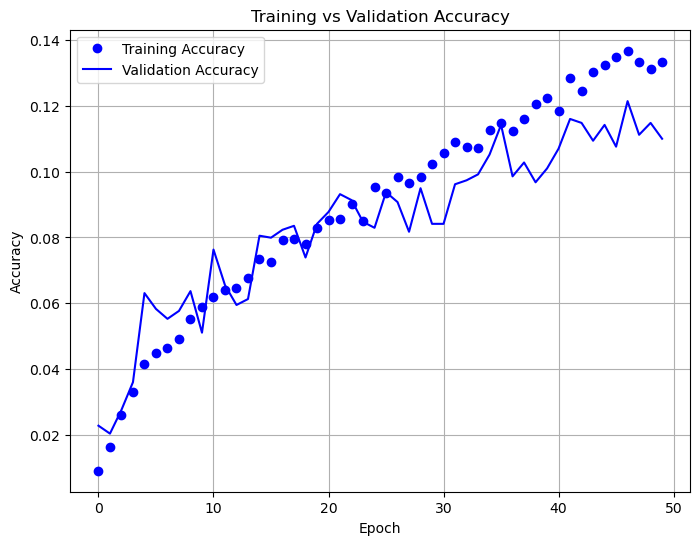

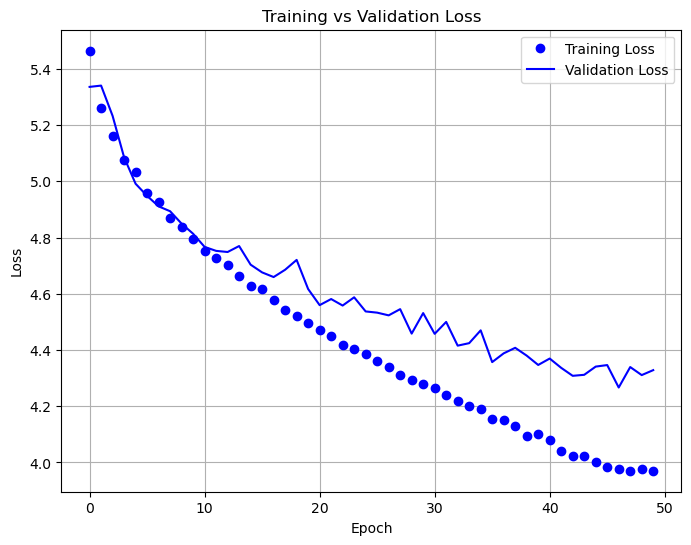

In [14]:
# Check what's available
print("Available history keys:", history.history.keys())

# Use exact metric keys
acc = history.history.get('accuracy') or history.history.get('categorical_accuracy')
val_acc = history.history.get('val_accuracy') or history.history.get('val_categorical_accuracy')
loss = history.history['loss']
val_loss = history.history['val_loss']

# Optional: If you computed macro F1 during training (custom callback), include it
macro_f1 = history.history.get('macro_f1')
val_macro_f1 = history.history.get('val_macro_f1')

# === Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(acc, 'bo', label='Training Accuracy')
plt.plot(val_acc, 'b', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# === Plot loss
plt.figure(figsize=(8, 6))
plt.plot(loss, 'bo', label='Training Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# === (Optional) Plot Macro F1 if manually logged
if macro_f1 and val_macro_f1:
    plt.figure(figsize=(8, 6))
    plt.plot(macro_f1, 'go', label='Training Macro F1')
    plt.plot(val_macro_f1, 'g', label='Validation Macro F1')
    plt.title('Macro F1-score over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Macro F1')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def evaluate_metrics_only(model, test_generator):
    # Predict probabilities
    y_probs = model.predict(test_generator, verbose=1)

    # Convert to predicted class indices
    y_pred = np.argmax(y_probs, axis=1)

    # Get true class indices from generator
    y_true = test_generator.classes[:len(y_pred)]

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    # Print results
    print("\nEvaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1-score: {macro_f1:.4f}")
    print(f"Weighted F1-score: {weighted_f1:.4f}")
    print(f"Macro Precision: {precision:.4f}")
    print(f"Macro Recall: {recall:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))

# Use it
evaluate_metrics_only(model, test_generator)

27/27 [==============================] - 45s 2s/step

Evaluation Metrics:
Accuracy: 0.1034
Macro F1-score: 0.0845
Weighted F1-score: 0.0897
Macro Precision: 0.1036
Macro Recall: 0.1266

Classification Report:
               precision    recall  f1-score   support

           0     0.5667    0.7727    0.6538        22
           1     0.0500    0.2000    0.0800         5
           2     0.0000    0.0000    0.0000         9
           3     0.0000    0.0000    0.0000         4
           4     0.1818    0.4000    0.2500         5
           5     1.0000    0.1842    0.3111        38
           6     0.1429    0.1111    0.1250         9
           7     0.0000    0.0000    0.0000         5
           8     1.0000    0.2500    0.4000         4
           9     0.0244    0.2500    0.0444         4
          10     0.0714    0.8000    0.1311         5
          11     0.3333    0.2500    0.2857         4
          12     0.2000    0.5000    0.2857         4
          13     0.0000    0.0000

c:\Users\Elcano\anaconda3\envs\cv310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Elcano\anaconda3\envs\cv310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Elcano\anaconda3\envs\cv310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\U